In [1]:
! pip install -r requirement

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirement'

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# library

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import PIL
from tensorflow.keras.callbacks import ModelCheckpoint


# creating a pandas dataframe

Contains the filepath, labels, 

In [3]:
#picking only 20 image per category

list_dir = "C:/Users/Avinash/Desktop/Resume_Projects/multiple_object_detection/dataset"
file_names_list = os.listdir(list_dir) #for getting the list of files names
label = 0 #initialized the label key word for counting the labels.
plant_data = {} #for creating the dictionary 
list_of_files = [] #for storing the image path 
list_of_categories = [] #for storing the category names
list_of_labels = [] #for storing the labels
for filename in file_names_list:
    # print("The file name is:",filename) 
    label += 1
    file_path = f"C:/Users/Avinash/Desktop/Resume_Projects/multiple_object_detection/dataset/{filename}"
    filedata = os.listdir(file_path)
    
    print("The file data:",filedata)
    
    length_of_data = len(filedata)
    if length_of_data > 50:
        
        listdata = filedata[:50]
        for data in listdata:
            # print("The data:",data)
            image_path = f"C:/Users/Avinash/Desktop/Resume_Projects/multiple_object_detection/dataset/{filename}/{data}"
            #print("The image path:",image_path)
            list_of_files.append(image_path)
            list_of_categories.append(filename)
            list_of_labels.append(label)

data = {"File_Path":list_of_files,
        "Category_Names":list_of_categories,
        "Labels":list_of_labels ,
        }
df = pd.DataFrame(data)
# print("The shape of the dataset:",df.shape)

The file data: ['0050f38b3.png', '0183fdf68.png', '0260cffa8.png', '05eedce4d.png', '075d004bc.png', '078eae073.png', '082314602.png', '0ace21089.png', '0b228a6b8.png', '0b3e7a7a9.png', '0bb75ded8.png', '0be707615.png', '0c67c3fc3.png', '0d1a9985f.png', '0d28c429b.png', '0d4f74f4a.png', '0dad57e7f.png', '0e91f92a1.png', '0fe440ed5.png', '1276dffba.png', '129c51855.png', '13a7f553a.png', '14719a83e.png', '1576ce9fd.png', '163c13912.png', '163e571a6.png', '16c69a6d8.png', '173cec485.png', '1a125880e.png', '1af1eddd3.png', '1d39b8f30.png', '1e49633e0.png', '20b2cbaed.png', '20d4fab57.png', '2269e0a1e.png', '228d8ad5c.png', '22be204a3.png', '25daae389.png', '260c4eed3.png', '26103af9c.png', '279ac215b.png', '28a707630.png', '2aa60045d.png', '2ed589264.png', '2ee4dad8c.png', '2f0ae1b34.png', '2f6bc240a.png', '3002e5d9d.png', '31958c132.png', '31f2766cb.png', '32d97b170.png', '332f68a21.png', '34a672a63.png', '355cad34c.png', '37d85d833.png', '39e9bf4c7.png', '3a8c485bc.png', '3b7266ac3.png'

In [4]:
# divide the dataset in to features and classess (label)
x = df["File_Path"]
y = df["Category_Names"]

In [65]:
df.shape

(600, 3)

# Preprocesing the image 

In [27]:
#we are resizing the image to 70*70
trainImg = []

# Obtain images and resizing, obtain labels

for file in df["File_Path"].values:
    trainImg.append(cv2.resize(cv2.imread(file), (70, 70)))   # Get image (with resizing)
    
trainImg = np.asarray(trainImg)  # Train images set converting them into arrays

# Converting labels into categorical 

In [6]:
# Encode labels and create classes
from sklearn import preprocessing
import matplotlib.pyplot as plt

le = preprocessing.LabelEncoder()
le.fit(y)
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(y)

# Make labels categorical
clearTrainLabel = tf.keras.utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common-Chickweed' 'Common-wheat'
 'Fat-Hen' 'Loose-Silky-bent' 'Maize' 'Scentless-Mayweed'
 'Shepherds-Purse' 'Small-flowered-Cranesbill' 'Sugar-beet']
Number of classes: 12


# Preprocessing the image
# Resize the image (2)
#

In [7]:
# #preprocess the images in to 1 to 255 it is in RGB
# trainImg = trainImg / 255

In [28]:
# Get the clear image 
# step 1:- Reducing the Noise by applying the GaussianBlur on the image
# step 2:- Applying HSV on the blur image; output a image color with HSV (Which helps to make the RGB colour )
# step 3:- Creating mask based on the empirical range.
# step 4:- Convert into boolean mask and apply it on the origin image.

clearTrainImg = [] #list to save the cleared train image

for img in trainImg:
    
    #converting the image frame to GaussianBlur 
    #ksize − A Size object representing the size of the kernel.
    #sigmaX- A variable of the type double representing the Gaussian kernel standard deviation in X direction.
    gaussblur = cv2.GaussianBlur(img,(5,5),0)
    
    #convert the gaussblur to hsv image
    hsv_image = cv2.cvtColor(gaussblur,cv2.COLOR_BGR2HSV) 
    
    #creating the mask for the hsv_image 
    lower_green = (25,40,50)
    higher_green = (75,255,255) 
    mask = cv2.inRange(hsv_image,lower_green,higher_green) 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) 
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)  
    
    #create bool mask 
    bMask = mask > 0  
    
    #apply the mask to the image
    clear = np.zeros_like(img,np.uint8) #return with the same image shape 
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without background
    
    
clearTrainImg = np.array(clearTrainImg)  
    
    

In [29]:
#spliting the data set in to train test
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(clearTrainImg,clearTrainLabel,test_size=0.2,random_state=42)

In [30]:
from tensorflow.keras.layers import BatchNormalization #normalizing the input data.
from tensorflow.keras.models import Sequential #for making the modeles.
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout #Using the build the CNN network.

In [31]:
ScaleTo = 70
nb_classes = 12
# #create a graph
# model = Sequential()
# model.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),input_shape=(ScaleTo,ScaleTo,3),activation="relu")) #for the kernel size 3*3 we get the information
# ''' 
# BatchNormalization normalize the inputs of a neural network layer. 
# This helps stabilize the learning process and reduces the number of training epochs required to train deep networks.
# '''
# model.add(tf.keras.layers.BatchNormalization(axis=3)) #normalizing the input image data features
# model.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),activation="relu")) #for the kerel 3*3
# model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3))) #Getting the maximum out of that kernel size
# model.add(tf.keras.layers.BatchNormalization(axis=3)) #BatchNormaling the input data
# model.add(tf.keras.layers.Dropout(0.1))


# model.add(tf.keras.layers.Conv2D(32,kernel_size = (3,3),activation="relu"))
# model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))
# model.add(tf.keras.layers.BatchNormalization(axis=3)) #axis=3: This parameter specifies the axis that should be normalized.
# model.add(tf.keras.layers.Dropout(0.1))

# model.add(tf.keras.layers.Conv2D(32,kernel_size = (3,3),activation="relu"))
# model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3)))
# model.add(tf.keras.layers.BatchNormalization(axis=3))
# model.add(tf.keras.layers.Dropout(0.1))


# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64,activation="relu"))
# model.add(tf.keras.layers.Dense(126,activation="relu"))
# model.add(tf.keras.layers.Dropout(0.15))
# model.add(tf.keras.layers.Dense(13,activation="softmax"))

# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
# callbacks = tf.keras.callbacks.EarlyStopping(monitor="loss",mode="min",patience=2)

model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(ScaleTo,ScaleTo,3),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=(3)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis=3))
model.add((Dropout(0.1)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(nb_classes,activation='softmax'))

model.summary()

c:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\cropenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 66, 66, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 66, 66, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 27, 27, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 23, 23, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,320,396 (12.67 MB)

 Trainable params: 3,317,580 (12.66 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [32]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [33]:
checkpoint = ModelCheckpoint("model_weights.keras",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

In [34]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

In [35]:
#batch size represents the number of traning examples used in one iteration
train_generator = datagen.flow(x_train,y_train,batch_size=32,shuffle=True,seed=42)
Validation_generator = datagen.flow(x_test,y_test,batch_size=32,shuffle=True,seed=42)

In [45]:
epochs = 40
batch_size = 15
history = model.fit(train_generator,
                              epochs=epochs,
                              validation_data=Validation_generator,
                              callbacks=callbacks_list,
                              verbose=1)

c:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\cropenv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\cropenv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4258 - loss: 1.6841
Epoch 1: val_accuracy did not improve from 0.35000
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4258 - loss: 1.6843 - val_accuracy: 0.2667 - val_loss: 4.3348
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4717 - loss: 1.5510
Epoch 2: val_accuracy improved from 0.35000 to 0.56667, saving model to model_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.4729 - loss: 1.5493 - val_accuracy: 0.5667 - val_loss: 1.4682
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4317 - loss: 1.7918
Epoch 3: val_accuracy did not improve from 0.56667
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4318 - loss: 1.7871 - val_accuracy: 0.1083 - val_loss: 5.7616
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4314 - loss: 1.6714
Epoch 4: val_accuracy did not improve from 0.56667
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4311 - loss: 1.6727 - val

In [46]:
model.evaluate(x_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 0.6019 - loss: 2.8596


[2.8696131706237793, 0.574999988079071]

In [47]:
# printing the list of labels
labels = ['Black-grass','Charlock','Cleavers','Common-Chickweed','Common-wheat'
,'Fat-Hen','Loose-Silky-bent','Maize','Scentless-Mayweed'
,'Shepherds-Purse','Small-flowered-Cranesbill','Sugar-beet'] 

In [48]:
def test_image(img):
       #converting the image frame to GaussianBlur 
    #ksize − A Size object representing the size of the kernel.
    #sigmaX- A variable of the type double representing the Gaussian kernel standard deviation in X direction.
    gaussblur = cv2.GaussianBlur(img,(5,5),0)
    
    #convert the gaussblur to hsv image
    hsv_image = cv2.cvtColor(gaussblur,cv2.COLOR_BGR2HSV) 
    
    #creating the mask for the hsv_image 
    lower_green = (25,40,50)
    higher_green = (75,255,255) 
    mask = cv2.inRange(hsv_image,lower_green,higher_green) 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) 
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)  
    
    #create bool mask 
    bMask = mask > 0  
    
    #apply the mask to the image
    clear = np.zeros_like(img,np.uint8) #return with the same image shape 
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    return clear 

The shape (51, 51, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
The result: [[0.00175954 0.0153666  0.03243015 0.00808701 0.00252126 0.00132753
  0.00216868 0.03877214 0.8294917  0.05393597 0.00530075 0.00883884]]
The index value is: 8
The label: Scentless-Mayweed


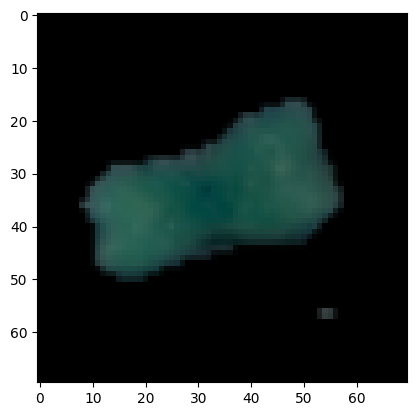

In [62]:
#C:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\dataset\Sugar-beet\f506aa640.png 
#C:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\dataset\Small-flowered-Cranesbill\0b26e2d09.png

#prediciting the image
frame = cv2.imread(r"C:\Users\Avinash\Desktop\Resume_Projects\multiple_object_detection\dataset\Scentless-Mayweed\0d58d5433.png")
# frame = mask_image(frame)
frame = test_image(frame)
# frame = x_test[0]
print("The shape",frame.shape)
frame = cv2.resize(frame,(70, 70))
#show the image
plt.imshow(frame)
frame = frame.reshape(1,70, 70, 3)
result = model.predict(frame) #predicting the result
print("The result:",result)
#Getting the index from the result
index = result.argmax() #getting the max value index
print("The index value is:",index)
#getting the label
resulted_label = labels[index]

#printing the label
print("The label:",resulted_label)

In [63]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\Avinash\AppData\Local\Temp\tmpbpf296vz\assets


INFO:tensorflow:Assets written to: C:\Users\Avinash\AppData\Local\Temp\tmpbpf296vz\assets


Saved artifact at 'C:\Users\Avinash\AppData\Local\Temp\tmpbpf296vz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name='keras_tensor_352')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  2036277743632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277744208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277743248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277743824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277744400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277744016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277745936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277746512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277746320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2036277744976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [64]:
# Save the model.
with open('model.pt', 'wb') as f:
  f.write(tflite_model)